<a href="https://colab.research.google.com/github/Vishwajit-hegde/Driver-Performance-Analysis/blob/master/Driver_event_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from datetime import datetime
from matplotlib import pyplot as plt
from matplotlib import dates as md
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv1D, Dense, Activation, Dropout, Lambda, Multiply, Add, Concatenate
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D,Conv2D,LSTM,GRU,Lambda
from tensorflow.keras.layers import MaxPooling1D, Bidirectional
import datetime
from tqdm import tqdm
from sklearn.utils import shuffle
import os
from scipy import signal
import gc

In [67]:
df=pd.DataFrame()
df1 = pd.DataFrame()
os.chdir('/content/drive/My Drive/labelled_driver_data')
for files in os.listdir(os.getcwd()):
  print(files)
  if files!='river4':
    os.chdir('/content/drive/My Drive/labelled_driver_data/{}'.format(files))
    for filename in os.listdir(os.getcwd()):
        print(filename)
        if 'acelerometro' in filename:
          data = pd.read_csv(filename ,sep =',', header = 0 )
          data.columns=['timestamp','uptimeNanos','X','Y','Z']
          data['label'] = 0
          data['device'] = 'acc'
          data['uptimeNanos'] /= 1e9
        elif 'giro' in filename:
          data2 = pd.read_csv(filename ,sep =',', header = 0 )
          data2.columns=['timestamp','uptimeNanos','X','Y','Z']
          data2['label'] = 0
          data2['device'] = 'gyr'
          data2['uptimeNanos'] /= 1e9
        elif 'ground' in filename:
          labels = pd.read_csv(filename , sep=',')
          labels[' inicio'] += data['uptimeNanos'][0]
          labels[' fim'] += data['uptimeNanos'][0]

    for event,start, end in labels.values:
        #print(data2.loc[data2.uptimeNanos.between(start, end),['label']].shape[0])
        data.loc[data.uptimeNanos.between(start, end),['label']] = [event]
        data2.loc[data2.uptimeNanos.between(start, end),['label']] = [event]
    df1 = pd.concat([data,data2], axis =1 , ignore_index=True)
    df = df.append(df1)
    del data, data2, labels

driver4
acelerometro_terra.txt
giroscopio_terra.txt
groundTruth.txt
aceleracaoLinear_terra.txt
driver3
acelerometro_terra.txt
giroscopio_terra.txt
groundTruth.txt
aceleracaoLinear_terra.txt
driver1
acelerometro_terra.txt
groundTruth.txt
giroscopio_terra.txt
aceleracaoLinear_terra.txt
driver2
acelerometro_terra.txt
giroscopio_terra.txt
groundTruth.txt
aceleracaoLinear_terra.txt


In [117]:
df.label.value_counts(normalize=True)

0    0.945378
1    0.054622
Name: label, dtype: float64

In [119]:
df['time'] = df.timedate.apply(lambda x : x.time())
print('The sampling frequency in Hz is:',df.groupby('time').X_gyr.count().mean())

The sampling frequency in Hz is: 50.8816644993498


In [120]:
print('total time in min',(df.shape[0]/50)/60)

total time in min 52.17066666666666


In [69]:
df.columns =['timedate','time','X_acc','Y_acc','Z_acc','label','device','s','s1','X_gyr','Y_gyr','Z_gyr','s2','s3']
df.timedate = pd.to_datetime(df.timedate)
df['label'] = df.label.apply(lambda x : 0 if x in ['evento_nao_agressivo',0] else 1)

In [74]:
df = df[['timedate','time','X_acc','Y_acc','Z_acc','X_gyr','Y_gyr','Z_gyr','label']]

In [34]:
df.head()

,timedate,time,X_acc,Y_acc,Z_acc,X_gyr,Y_gyr,Z_gyr,label
0,2016-05-15 16:03:47,16:03:47,0.336558,-0.169031,9.658637,0.031439,0.360042,0.009180,0
1,2016-05-15 16:03:47,16:03:47,2.022178,-0.125877,9.948004,0.235446,0.680577,-0.039432,0
2,2016-05-15 16:03:47,16:03:47,0.777634,-0.088642,11.809340,0.118159,0.084886,-0.087033,0
3,2016-05-15 16:03:47,16:03:47,-0.695542,-0.127862,8.672421,-0.176048,-0.288289,0.070482,0
4,2016-05-15 16:03:47,16:03:47,-1.864220,0.843311,8.023548,-0.137060,-0.123618,0.051219,0


In [75]:
df.dropna(inplace = True)
df.label.value_counts(normalize=True)

In [77]:
dftrain = df.copy()

In [47]:
#Z is lateral 
#X is logitudinal
#Y vertical

In [82]:
def train_dataset(series,window_size, batch_size):
    ds = tf.data.Dataset.from_tensor_slices((series))
    ds = ds.window(window_size, shift=20, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.shuffle(10000).map(lambda window: (window[:,:-1], window[50,-1:]))
    #ds = ds.batch(batch_size).prefetch(1)
    return ds

In [83]:
train= train_dataset(dftrain[['X_acc','Y_acc','Z_acc','X_gyr','Y_gyr','Z_gyr','label']].values,100,128)

In [84]:
X=[]
y=[]
for i,j in train:
  X.append(i.numpy())
  y.append(j.numpy())
X = np.asarray(X)
y = np.asarray(y)

In [107]:
def create_model(n, n_filters =32, filter_width = 2 , dilation_rates =[2**i for i in range(8)] * 2 ):

  # define an input history series and pass it through a stack of dilated causal convolution blocks. 
  history_seq = Input(shape=(100, n))
  x = history_seq

  skips = []
  for dilation_rate in dilation_rates:
      
      # preprocessing - equivalent to time-distributed dense
      x = Conv1D(16, 1, padding='same', activation='relu')(x) 
      
      # filter convolution
      x_f = Conv1D(filters=n_filters,
                  kernel_size=filter_width, 
                  padding='causal',
                  dilation_rate=dilation_rate)(x)
      
      # gating convolution
      x_g = Conv1D(filters=n_filters,
                  kernel_size=filter_width, 
                  padding='causal',
                  dilation_rate=dilation_rate)(x)
      
      # multiply filter and gating branches
      z = Multiply()([Activation('tanh')(x_f),
                      Activation('sigmoid')(x_g)])
      
      # postprocessing - equivalent to time-distributed dense
      z = Conv1D(16, 1, padding='same', activation='relu')(z)
      
      # residual connection
      x = Add()([x, z])    
      
      # collect skip connections
      skips.append(z)

  # add all skip connection outputs 
  out = Activation('relu')(Add()(skips))

  # final time-distributed dense layers 
  out = Conv1D(100, 1, padding='same')(out)
  out = Activation('relu')(out)
  out = Dropout(.2)(out)
  out = Conv1D(1,1, padding='same')(out)
  out = Flatten()(out)
  out = Dense(100, activation='relu')(out)
  out = Dropout(.3)(out)
  out = Dense(10, activation='relu')(out)
  out = Dense(1, activation='sigmoid')(out)

  model = Model(history_seq, out)
  model.compile(tf.keras.optimizers.Adam(lr = 1e-4), loss='binary_crossentropy', metrics =METRICS)
  return model

In [95]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 6)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 100, 16)      112         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 100, 32)      1056        conv1d[0][0]                     
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 100, 32)      1056        conv1d[0][0]                     
_______________________________________________________________________________________

In [96]:
weight_for_0 = (1 / 110178)*(116512)/2.0
weight_for_1 = (1 / 6334)*(116512)/2.0

class_weight = {0: 1, 1: 2}
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.Binaryy_train.sum()/y_train.shape[0]Accuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc')
]


In [110]:
auc =[]
val_auc =[]
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=3, test_size=0.25, random_state=47)
for train_index, test_index in sss.split(X, y):
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]
  model = create_model(6)
  history = model.fit(X_train, y_train,batch_size =64,  epochs =50, validation_data=(X_test, y_test),verbose = 10,validation_batch_size=64,callbacks =[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)])
  if history.history['accuracy']> 0.95 and history.history['val_accuracy'] >0.95:
    print('The model is better than a simple constant model for sure:')
    auc.append(history.history['auc'][-7])
    val_auc.append(history.history['val_auc'][-7])


Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50
Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/50
Epoch 36/50
Epoch 37/50
Epoch 38/50
Epoch 39/50
Epoch 40/50
Epoch 41/50
Epoch 42/50
Epoch 43/50
Epoch 44/50
Epoch 45/50
Epoch 46/50
Epoch 47/50
Epoch 48/50
Epoch 49/50
Epoch 50/50
Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50
Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/5

In [111]:
auc

[0.9384036660194397, 0.9852524995803833, 0.9708595275878906]

In [112]:
val_auc

[0.9606329798698425, 0.9770627021789551, 0.9812782406806946]

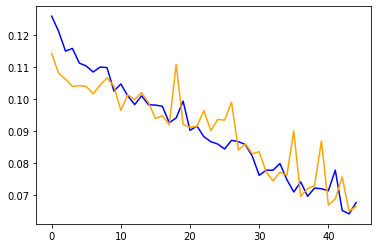

In [113]:
plt.plot(history.history['loss'][5:], color ='blue')
plt.plot(history.history['val_loss'][5:], color ='orange')

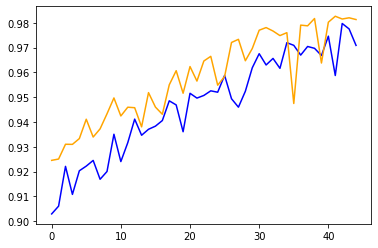

In [116]:
plt.plot(history.history['auc'][5:], color ='blue')
plt.plot(history.history['val_auc'][5:], color ='orange')